In [137]:
import os
import sys
print("Python version" + sys.version)
os.getcwd()
print(sys.executable)

Python version3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) 
[GCC 9.4.0]
/fast/users/twei_m/work/miniconda/envs/sc/bin/python


In [138]:
import numpy as np
np.random.seed(123)
import pandas as pd
import scipy
import itertools

import umap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scanpy as sc
import anndata as ad
import scvelo as scv
from tqdm.notebook import tqdm

from pathlib import Path

In [139]:
import scrublet as scr

In [140]:
sc.settings.verbosity = 1
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.4 scipy==1.9.1 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [141]:
# remove weird grid from scvelo
plt.rcParams['axes.grid'] = False

from cellbender_adata_fix import *

In [142]:
# revised from Stefan's cell type signature
signatures_path_ = '../cell_type_from_stefan/scrnaseq_signature_collection/'
from score_and_classify import *

In [143]:
data_folder = '/fast/users/twei_m/work/crc/datasets'

In [144]:
new_data_folder = '/fast/users/twei_m/work/crc/datasets_new_preprocessing'

### refer to 20221118_icms_classifier.ipynb

#### read Joanito et al, assumed only processed by CellRanger

In [145]:
import h5py

In [146]:
from scipy.sparse import csr_matrix

In [147]:
f = h5py.File(Path(data_folder)/'icms/Epithelial_Count_matrix.h5', 'r')

In [148]:
list(f.keys())

['matrix']

In [149]:
list(f['matrix'])

['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']

In [150]:
def _collect_datasets(dsets: dict, group: h5py.Group):
    for k, v in group.items():
        if isinstance(v, h5py.Dataset):
            dsets[k] = v[:]
        else:
            _collect_datasets(dsets, v)

In [151]:
with h5py.File(Path(data_folder)/'icms/Epithelial_Count_matrix.h5', 'r') as f:
    dsets = {}
    _collect_datasets(dsets, f["matrix"])
    M, N = dsets['shape']
    data = dsets['data']
    matrix = csr_matrix(
                (data, dsets['indices'], dsets['indptr']),
                shape=(N, M),
            )

In [152]:
joanito = ad.AnnData(
                matrix,
                obs=dict(obs_names=dsets['barcodes'].astype(str)),
                var=dict(
                    var_names=dsets['name'].astype(str),
                    #gene_ids=dsets['id'].astype(str),
                    feature_types=dsets['feature_type'].astype(str),
                    genome=dsets['genome'].astype(str),
                ),
            )

joanito = anndata_from_h5(Path(data_folder)/'icms/Epithelial_Count_matrix.h5')

In [153]:
joanito.shape

(49155, 33287)

In [154]:
metadata = pd.read_csv(Path(data_folder)/'icms/Epithelial_metadata.csv', index_col=0)

In [155]:
metadata['dataset'].value_counts()

CRC-SG1    15920
SMC        15570
CRC-SG2     8744
KUL3        5582
KUL5        3339
Name: dataset, dtype: int64

In [156]:
metadata = metadata.reindex(joanito.obs.index)

In [157]:
joanito.obs = metadata

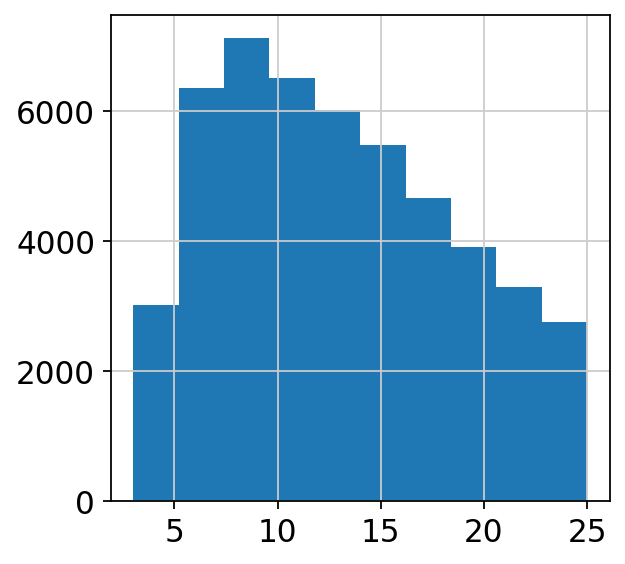

In [158]:
joanito.obs['percent.mt'].hist();

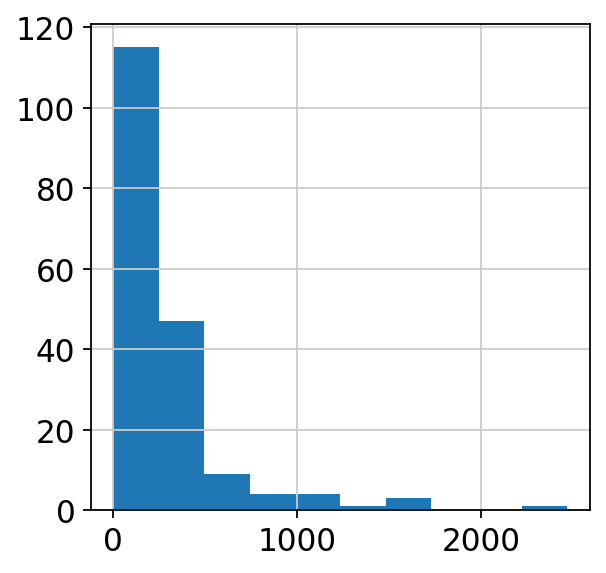

In [159]:
joanito.obs['sample.ID'].value_counts().hist();

In [160]:
joanito.var['mt'] = joanito.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(joanito, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

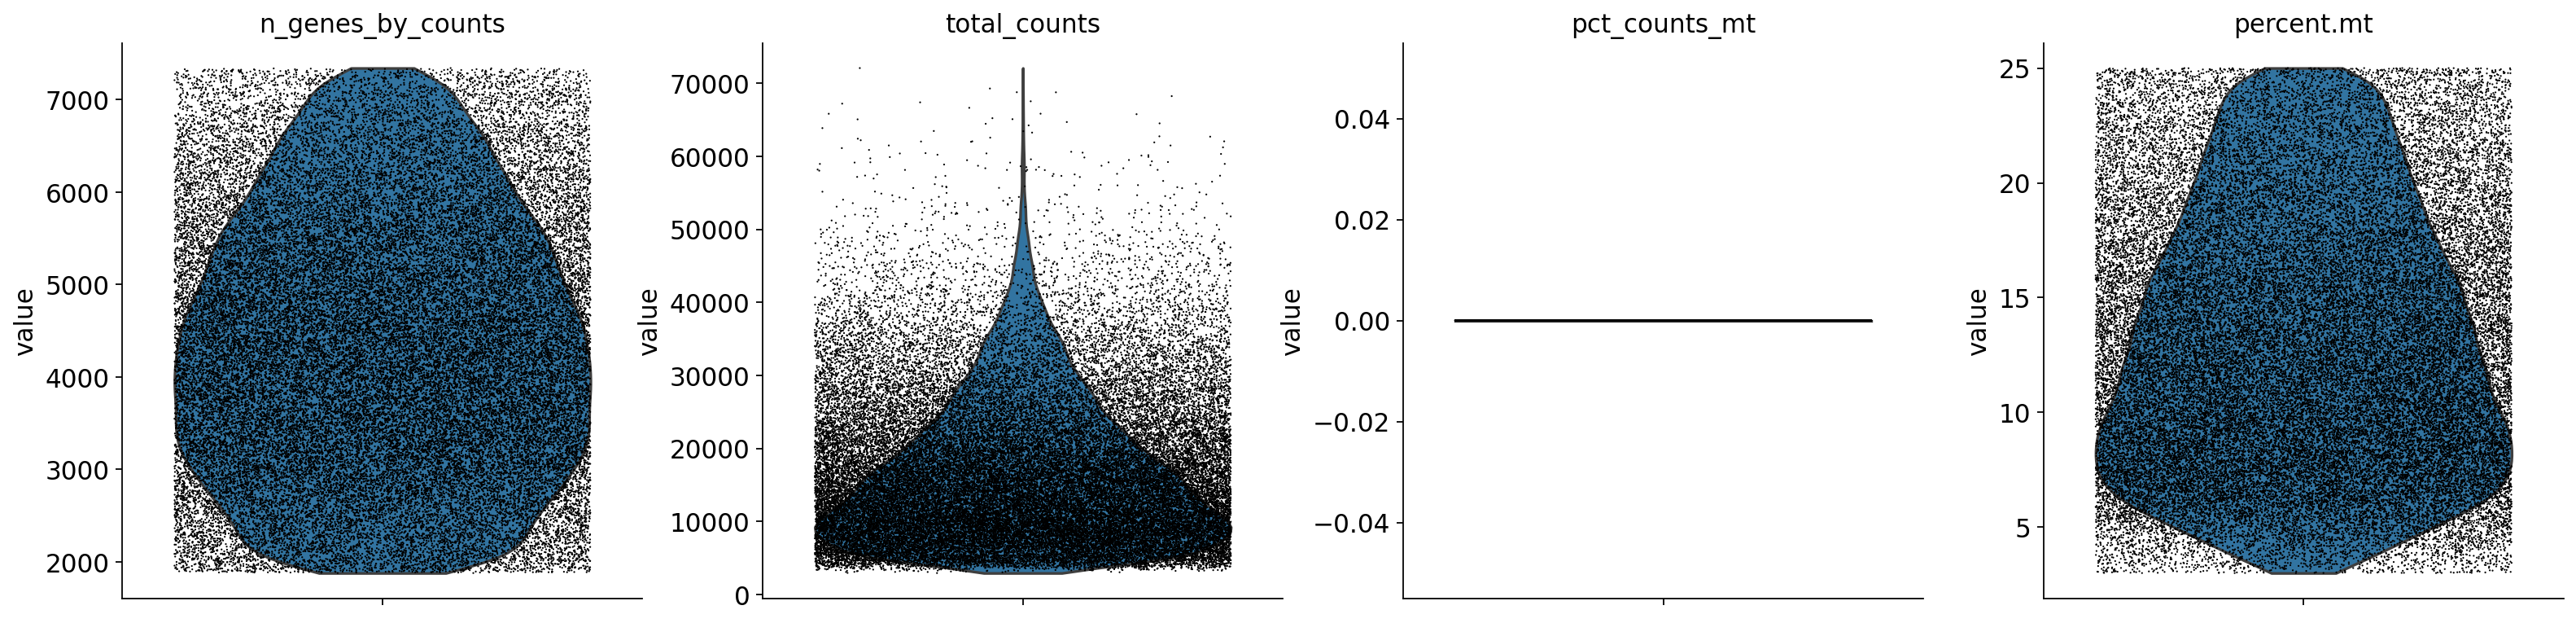

In [161]:
sc.pl.violin(joanito, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'percent.mt'],
             jitter=0.4, multi_panel=True)

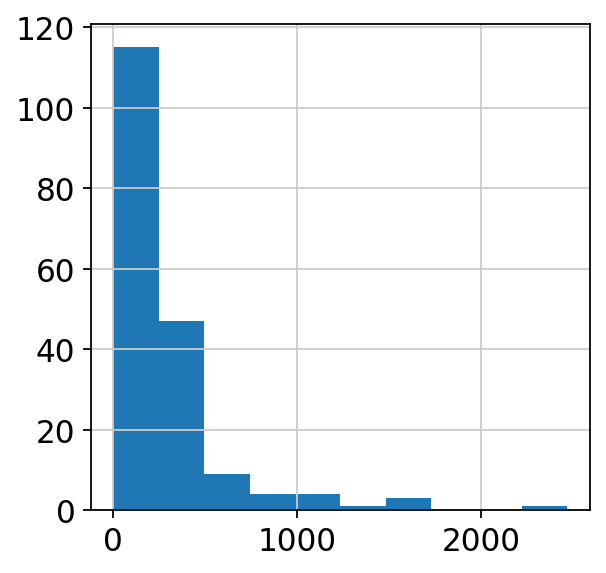

In [162]:
joanito.obs['sample.ID'].value_counts().hist();

### no scrublet because some samples have really low number of cells

In [163]:
joanito.layers['counts'] = joanito.X.copy()

In [164]:
joanito.shape

(49155, 33287)

In [165]:
sc.pp.filter_cells(joanito, min_counts=1000)  # uhlitz
#sc.pp.filter_cells(adata_all, max_counts=50000)  # uhlitz
sc.pp.filter_cells(joanito, min_genes=500)  # uhlitz
#sc.pp.filter_cells(adata_all, max_genes=5000)  # uhlitz

In [166]:
joanito.shape

(49155, 33287)

In [167]:
sc.pp.filter_genes(joanito, min_cells=1)

In [168]:
joanito.shape

(49155, 29143)

In [169]:
sc.pp.normalize_per_cell(joanito)
sc.pp.log1p(joanito)

In [170]:
score_cell_cycle(joanito, signatures_path_)

In [171]:
joanito.obs['sample.ID'].value_counts()

SMC16-T                   2467
SMC21-T                   1583
SMC22-T                   1569
SMC09-T                   1528
SMC18-T                   1439
                          ... 
SMC05-T                      5
CRC-JSC-S15-GIS-N-US-1       4
EXT023                       4
XHC080                       1
MUX9380                      1
Name: sample.ID, Length: 184, dtype: int64

In [172]:
joanito.obs['patient.ID'].value_counts()

SMC16          2467
CRC2841        2422
CRC-JSC-S05    2197
CRC-JSC-S10    1805
CRC2899        1731
               ... 
CRC-JSC-S15     155
SMC14           108
SC029            97
SMC05            49
SC028            41
Name: patient.ID, Length: 63, dtype: int64

In [173]:
sc.pp.highly_variable_genes(joanito, n_top_genes=2000, batch_key= 'patient.ID')
# cannot use sample ID as batch key because some only have one cell

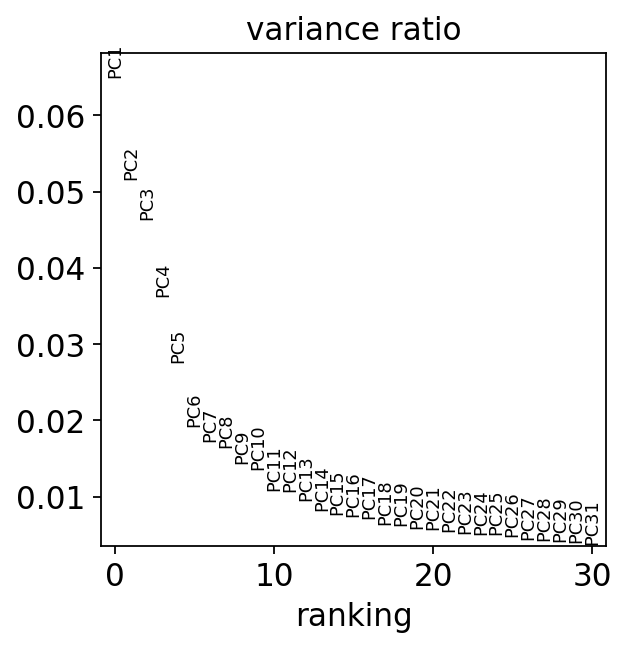

In [174]:
sc.tl.pca(joanito, svd_solver='arpack', n_comps = 50, use_highly_variable=True)
sc.pl.pca_variance_ratio(joanito, log=False)

In [175]:
sc.pp.neighbors(joanito, n_neighbors=50, n_pcs=30)
sc.tl.umap(joanito)
sc.tl.louvain(joanito, key_added='louvain', resolution=1)
sc.tl.leiden(joanito, key_added='leiden', resolution=1)

#### clean up a bit for later concat

In [176]:
joanito.obs['sample.origin'].cat.reorder_categories(['Normal', 'Tumor', 'Tumor-2', 'LymphNode'], inplace=True)

In [177]:
joanito.obs['MS_status'] = joanito.obs['msi'].cat.rename_categories({'MSI-H':'MSI'})

In [178]:
joanito.obs['MS_status'].value_counts(dropna=False)

MSS    38842
MSI    10313
Name: MS_status, dtype: int64

In [179]:
joanito.obs['sample'] = joanito.obs['sample.ID']
joanito.obs['patient'] = joanito.obs['patient.ID']
joanito.obs['sample_origin'] = joanito.obs['sample.origin']

joanito.write(os.path.join(new_data_folder, 'iCMS', '202305_joanito_epi_mtx_processed.h5'))